<a href="https://colab.research.google.com/github/alex-pakalniskis/DS-Unit-1-Sprint-3-Linear-Algebra/blob/master/module4-clustering/LS_DS_134_Clustering_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-Means Clustering

# 1) Use the "Breast Cancer Wisconsin (Diagnostic) Data Set" from Kaggle to try and cluster types of cancer cells. 

Here's the original dataset for your reference:

<https://www.kaggle.com/uciml/breast-cancer-wisconsin-data>

## This is a supervised learning dataset

(Because it has **labels** - The "diagnosis" column.)

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA # You don't necessarily have to use this
from sklearn.cluster import KMeans # You don't necessarily have to use this
from sklearn.preprocessing import StandardScaler # You don't necessarily have to use this

df = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/Cancer_Cells.csv")
print(df.shape)
df.head()

(569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Now it's an unsupervised learning dataset

(Because we've removed the diagnosis label) - Use this version.

In [2]:
df = df.drop('diagnosis', axis=1)
df.head()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Let's do it!

- You might want to do some data exploration to see if you can find specific columns that will help you find distinct clusters of cells
- You might want to use the elbow method to decide on the number of clusters to use.


In [0]:
# Perform K-Means Clustering on the Dataset

In [3]:
df_processed = df.copy()

df_processed.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


In [4]:
df_processed.drop(["Unnamed: 32"], axis=1, inplace=True)

df_processed.columns

Index(['id', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

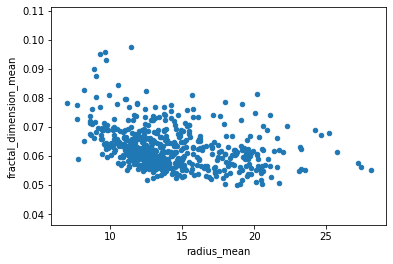

In [34]:
df_processed.plot.scatter("radius_mean", "fractal_dimension_mean")

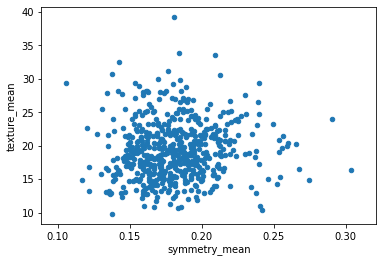

In [35]:
df_processed.plot.scatter("symmetry_mean", "texture_mean")

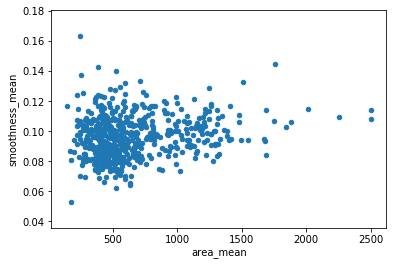

In [36]:
df_processed.plot.scatter("area_mean", "smoothness_mean")

In [37]:
df_processed.set_index("id").head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


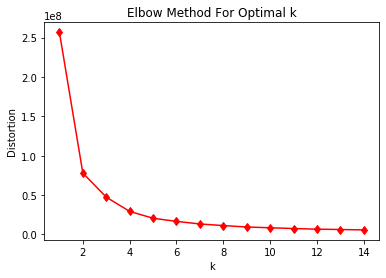

In [44]:
sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_processed.set_index("id"))
    sum_of_squared_distances.append(km.inertia_)

plt.plot(K, sum_of_squared_distances, 'rd-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method For Optimal k')
plt.show()

Let's go with two clusters. That's convenient for a benign/malignant diagnosis, but not for more nuanced differentiation of cancer cells. 

In [0]:
two_cluster_kmeans_labels = KMeans(n_clusters=2).fit(df_processed.set_index("id")).labels_

In [50]:
df_processed["Kmeans_2_cluster_label"] = pd.Series(two_cluster_kmeans_labels)


df_processed.head()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Kmeans_2_cluster_label
0,842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


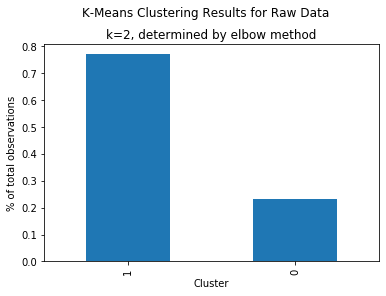

In [160]:
df_processed["Kmeans_2_cluster_label"].value_counts(normalize=True).plot(kind="bar")
plt.suptitle("K-Means Clustering Results for Raw Data", y=1.01)
plt.title("k=2, determined by elbow method")
plt.ylabel("% of total observations")
plt.xlabel("Cluster")
plt.show()

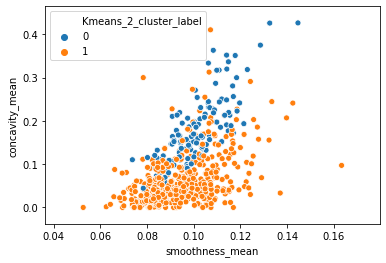

In [173]:
sns.scatterplot(data=df_processed, x="smoothness_mean", y="concavity_mean", hue="Kmeans_2_cluster_label")

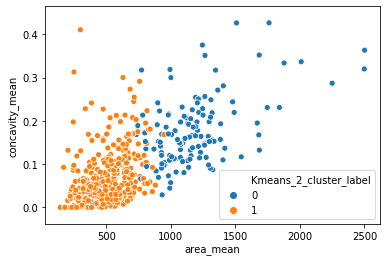

In [177]:
sns.scatterplot(data=df_processed, x="area_mean", y="concavity_mean", hue="Kmeans_2_cluster_label")

## Check you work: 

This is something that in a truly unsupervised learning situation **WOULD NOT BE POSSIBLE**. But for educational purposes go back and grab the true diagnosis column (label) from the original dataset. Take your cluster labels and compare them to the original diagnosis column. You can make scatterplots for each to see how they compare or you can calculate a percent accuracy score like: 
\begin{align}
\frac{\text{Num Correct Labels}}{\text{Num Total Observations}}
\end{align}

In [0]:
# Your Code Here

In [0]:
df_processed["diagnosis"] = df["diagnosis"].copy()

In [62]:
df_processed.head()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Kmeans_2_cluster_label,diagnosis
0,842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0,M
1,842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0,M
2,84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0,M
3,84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1,M
4,84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0,M


In [0]:
df_processed["diagnosis_int"] = df_processed["diagnosis"].map({"B":1,"M":0})

In [73]:
comparison_df = df_processed[["diagnosis_int","Kmeans_2_cluster_label"]].copy()

comparison_df

,diagnosis_int,Kmeans_2_cluster_label
0,0,0
1,0,0
2,0,0
3,0,1
4,0,0
...,...,...
564,0,0
565,0,0
566,0,1
567,0,0


In [76]:
comparison_df["cluster_label_matches_diagnosis"] =   comparison_df["Kmeans_2_cluster_label"].eq(comparison_df["diagnosis_int"]).copy()
comparison_df

,diagnosis_int,Kmeans_2_cluster_label,cluster_label_matches_diagnosis
0,0,0,True
1,0,0,True
2,0,0,True
3,0,1,False
4,0,0,True
...,...,...,...
564,0,0,True
565,0,0,True
566,0,1,False
567,0,0,True


In [77]:
comparison_df.groupby("Kmeans_2_cluster_label")["cluster_label_matches_diagnosis"].value_counts()

Kmeans_2_cluster_label  cluster_label_matches_diagnosis
0                       True                               130
                        False                                1
1                       True                               356
                        False                               82
Name: cluster_label_matches_diagnosis, dtype: int64

In [99]:
comparison_df.groupby("Kmeans_2_cluster_label")["cluster_label_matches_diagnosis"].value_counts(normalize=True).unstack()

cluster_label_matches_diagnosis,False,True
Kmeans_2_cluster_label,,
0,0.007634,0.992366
1,0.187215,0.812785


# 2) Perform PCA on your dataset first and *then* use k-means clustering. 

- You need to standardize your data before PCA.
- First try clustering just on PC1 and PC2 so that you can make a scatterplot of your clustering.
- Then use use a scree plot to decide how many principal components to include in your clustering, and use however many principal components you need in order to retain 90% of the variation of the original dataset



In [0]:
##### Your Code Here #####

In [100]:
df = df.drop('diagnosis', axis=1)
df.head()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [102]:
df_for_pca = df.drop(["Unnamed: 32"], axis=1).copy().set_index("id")

df_for_pca.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [103]:
scaler = StandardScaler()
df_for_pca = scaler.fit_transform(df_for_pca)
df_for_pca

array([[ 1.09706398, -2.07333501,  1.26993369, ...,  2.29607613,
         2.75062224,  1.93701461],
       [ 1.82982061, -0.35363241,  1.68595471, ...,  1.0870843 ,
        -0.24388967,  0.28118999],
       [ 1.57988811,  0.45618695,  1.56650313, ...,  1.95500035,
         1.152255  ,  0.20139121],
       ...,
       [ 0.70228425,  2.0455738 ,  0.67267578, ...,  0.41406869,
        -1.10454895, -0.31840916],
       [ 1.83834103,  2.33645719,  1.98252415, ...,  2.28998549,
         1.91908301,  2.21963528],
       [-1.80840125,  1.22179204, -1.81438851, ..., -1.74506282,
        -0.04813821, -0.75120669]])

Part 1: Clustering with two principal components

In [104]:
pca = PCA(2)
pca_features = pca.fit_transform(df_for_pca)

pca_features

array([[ 9.19283683,  1.94858307],
       [ 2.3878018 , -3.76817174],
       [ 5.73389628, -1.0751738 ],
       ...,
       [ 1.25617928, -1.90229671],
       [10.37479406,  1.67201011],
       [-5.4752433 , -0.67063679]])

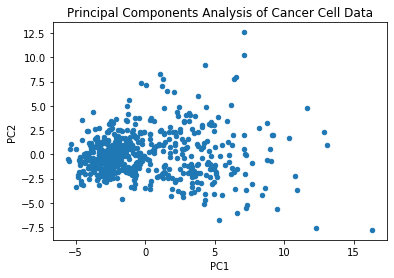

In [112]:
two_PC_df = pd.DataFrame(pca_features, columns=["PC1","PC2"])

two_PC_df.plot.scatter(x="PC1", y="PC2")

plt.title("Principal Components Analysis of Cancer Cell Data")

plt.show()

In [0]:
two_PC_kmeans_labels = KMeans(n_clusters=2).fit(two_PC_df).labels_


In [116]:
two_PC_df["Kmeans_2_cluster_label"] = pd.Series(two_PC_kmeans_labels)


two_PC_df.head()

,PC1,PC2,Kmeans_2_cluster_label
0,9.192837,1.948583,0
1,2.387802,-3.768172,0
2,5.733896,-1.075174,0
3,7.122953,10.275589,0
4,3.935302,-1.948072,0


In [0]:
import seaborn as sns

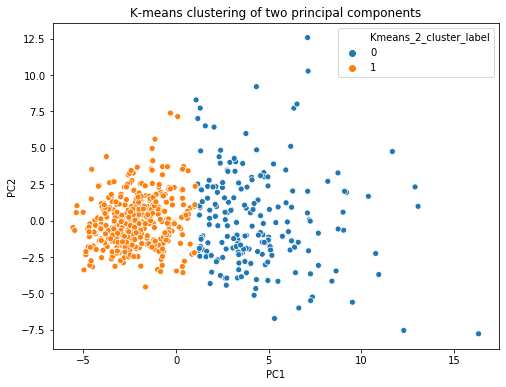

In [122]:
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.scatterplot(data=two_PC_df, x="PC1", y="PC2", hue="Kmeans_2_cluster_label")
plt.title("K-means clustering of two principal components")
plt.show()

Part 2: Let's make a scree plot

In [0]:
# Define scree plot function
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantiation of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(18, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s" % ((str(vals[i]*100)[:3])), (ind[i], vals[i]), va="bottom", ha="center", fontsize=8)
 
    ax.xaxis.set_tick_params(width=0)
    ax.set_yticklabels(["0", "20","40","60","80","100%"])
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

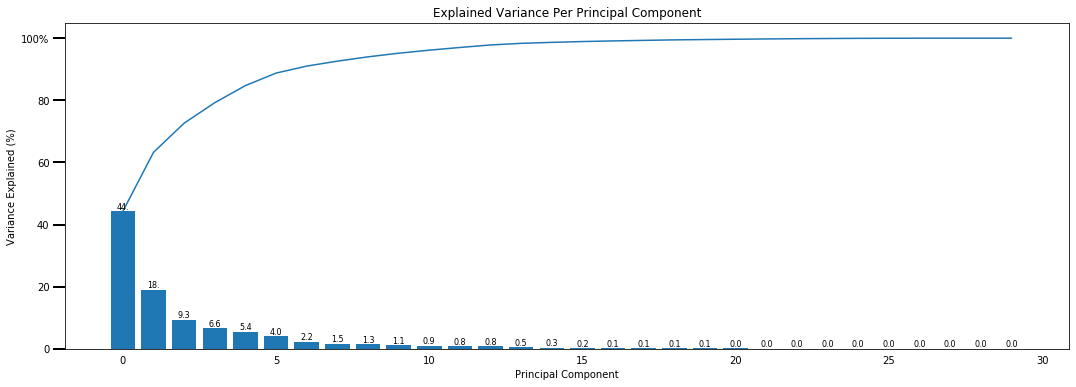

In [136]:
scree_plot(PCA().fit(df_for_pca))

Part 3: Retain enough principal components to maintain 90% of variance contained in raw data

In [147]:
ninety_percent_PC = PCA(0.9).fit_transform(df_for_pca)

ninety_percent_PC.shape

(569, 7)

In [148]:
ninety_percent_PC

array([[ 9.19283683,  1.94858307, -1.12316616, ..., -1.19511012,
         1.41142445,  2.15936987],
       [ 2.3878018 , -3.76817174, -0.52929269, ...,  0.62177498,
         0.02865635,  0.01335809],
       [ 5.73389628, -1.0751738 , -0.55174759, ..., -0.1770859 ,
         0.54145215, -0.66816648],
       ...,
       [ 1.25617928, -1.90229671,  0.56273053, ...,  1.80999133,
        -0.53444719, -0.19275823],
       [10.37479406,  1.67201011, -1.87702933, ..., -0.03374193,
         0.56793647,  0.22308167],
       [-5.4752433 , -0.67063679,  1.49044308, ..., -0.18470331,
         1.61783736,  1.69895156]])

In [145]:
df_for_pca.shape

(569, 30)

In [0]:
ninety_percent_PC_kmeans_labels = KMeans(n_clusters=2).fit(ninety_percent_PC).labels_


In [0]:
ninety_percent_labels_df = df.copy()

In [152]:
ninety_percent_labels_df["KMeansLabel"] = pd.Series(ninety_percent_PC_kmeans_labels)

ninety_percent_labels_df.head()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32,KMeansLabel
0,842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN,0
1,842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN,0
2,84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN,0
3,84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN,0
4,84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN,0


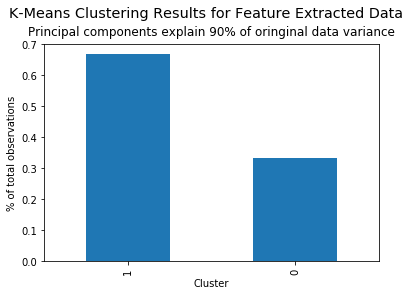

In [161]:
ninety_percent_labels_df["KMeansLabel"].value_counts(normalize=True).plot(kind="bar")
plt.suptitle("K-Means Clustering Results for Feature Extracted Data", y=1.01, size="x-large")
plt.title("Principal components explain 90% of oringinal data variance", y=1.01)
plt.ylabel("% of total observations")
plt.xlabel("Cluster")
plt.show()

## Check your work: 

- Compare your PC1, PC2 clustering scatterplot to the clustering scatterplots you made on the raw data


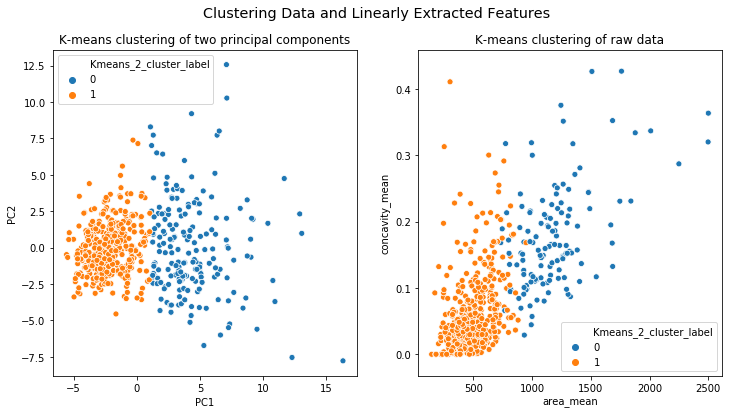

In [192]:
fig, ax = plt.subplots(1,2,sharex=False, sharey=False, figsize=(12,6))
sns.scatterplot(data=two_PC_df, x="PC1", y="PC2", hue="Kmeans_2_cluster_label", ax=ax[0])
sns.scatterplot(data=df_processed, x="area_mean", y="concavity_mean", hue="Kmeans_2_cluster_label", ax=ax[1])
ax[0].set_title("K-means clustering of two principal components")
ax[1].set_title("K-means clustering of raw data")
plt.suptitle("Clustering Data and Linearly Extracted Features", size="x-large")
plt.show()

Similar proportions of the total observations are clustered into the two KMeans groups for raw and feature extracted data sets. The Kmeans clustering results of principal compnents results in a straight line separating the data points in data space. In contrast, the clustering results obtained from raw data contain point labels which do not follow a strict linear separation. This may be an underlying strength/weakness of PCA feature extraction.

---

- Calculate accuracy scores for both the PC1,PC2 Principal component clustering and the 90% of explained variance clustering.

How do your accuracy scores -when preprocessing the data with PCA- compare to the accuracy when simply clustering on the raw data?

In [193]:
ninety_percent_principal_components = pd.DataFrame(ninety_percent_PC, columns=np.arange(1,8))

ninety_percent_principal_components.columns = "Principal Components " + ninety_percent_principal_components.columns.astype(str)

ninety_percent_principal_components["ClusterLabel"] = pd.Series(ninety_percent_PC_kmeans_labels)


ninety_percent_principal_components

,Principal Components 1,Principal Components 2,Principal Components 3,Principal Components 4,Principal Components 5,Principal Components 6,Principal Components 7,ClusterLabel
0,9.192837,1.948583,-1.123166,3.633731,-1.195110,1.411424,2.159370,0
1,2.387802,-3.768172,-0.529293,1.118264,0.621775,0.028656,0.013358,0
2,5.733896,-1.075174,-0.551748,0.912083,-0.177086,0.541452,-0.668166,0
3,7.122953,10.275589,-3.232790,0.152547,-2.960878,3.053422,1.429911,0
4,3.935302,-1.948072,1.389767,2.940639,0.546747,-1.226495,-0.936213,0
...,...,...,...,...,...,...,...,...
564,6.439315,-3.576817,2.459487,1.177314,-0.074824,-2.375193,-0.596130,0
565,3.793382,-3.584048,2.088476,-2.506028,-0.510723,-0.246710,-0.716326,0
566,1.256179,-1.902297,0.562731,-2.089227,1.809991,-0.534447,-0.192758,0
567,10.374794,1.672010,-1.877029,-2.356031,-0.033742,0.567936,0.223082,0


In [0]:
df = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/Cancer_Cells.csv")

In [197]:
ninety_percent_principal_components["diagnosis"] = df["diagnosis"].copy()

ninety_percent_principal_components

,Principal Components 1,Principal Components 2,Principal Components 3,Principal Components 4,Principal Components 5,Principal Components 6,Principal Components 7,ClusterLabel,diagnosis
0,9.192837,1.948583,-1.123166,3.633731,-1.195110,1.411424,2.159370,0,M
1,2.387802,-3.768172,-0.529293,1.118264,0.621775,0.028656,0.013358,0,M
2,5.733896,-1.075174,-0.551748,0.912083,-0.177086,0.541452,-0.668166,0,M
3,7.122953,10.275589,-3.232790,0.152547,-2.960878,3.053422,1.429911,0,M
4,3.935302,-1.948072,1.389767,2.940639,0.546747,-1.226495,-0.936213,0,M
...,...,...,...,...,...,...,...,...,...
564,6.439315,-3.576817,2.459487,1.177314,-0.074824,-2.375193,-0.596130,0,M
565,3.793382,-3.584048,2.088476,-2.506028,-0.510723,-0.246710,-0.716326,0,M
566,1.256179,-1.902297,0.562731,-2.089227,1.809991,-0.534447,-0.192758,0,M
567,10.374794,1.672010,-1.877029,-2.356031,-0.033742,0.567936,0.223082,0,M


In [198]:
ninety_percent_principal_components["diagnosis_int"] = ninety_percent_principal_components["diagnosis"].map({"B":1,"M":0})

ninety_percent_principal_components

,Principal Components 1,Principal Components 2,Principal Components 3,Principal Components 4,Principal Components 5,Principal Components 6,Principal Components 7,ClusterLabel,diagnosis,diagnosis_int
0,9.192837,1.948583,-1.123166,3.633731,-1.195110,1.411424,2.159370,0,M,0
1,2.387802,-3.768172,-0.529293,1.118264,0.621775,0.028656,0.013358,0,M,0
2,5.733896,-1.075174,-0.551748,0.912083,-0.177086,0.541452,-0.668166,0,M,0
3,7.122953,10.275589,-3.232790,0.152547,-2.960878,3.053422,1.429911,0,M,0
4,3.935302,-1.948072,1.389767,2.940639,0.546747,-1.226495,-0.936213,0,M,0
...,...,...,...,...,...,...,...,...,...,...
564,6.439315,-3.576817,2.459487,1.177314,-0.074824,-2.375193,-0.596130,0,M,0
565,3.793382,-3.584048,2.088476,-2.506028,-0.510723,-0.246710,-0.716326,0,M,0
566,1.256179,-1.902297,0.562731,-2.089227,1.809991,-0.534447,-0.192758,0,M,0
567,10.374794,1.672010,-1.877029,-2.356031,-0.033742,0.567936,0.223082,0,M,0


In [199]:
pca_comparison_df = ninety_percent_principal_components[["ClusterLabel","diagnosis_int"]]

pca_comparison_df

,ClusterLabel,diagnosis_int
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
564,0,0
565,0,0
566,0,0
567,0,0


In [202]:
pca_comparison_df["cluster_label_matches_diagnosis"] =   pca_comparison_df["ClusterLabel"].copy().eq(pca_comparison_df["diagnosis_int"].copy())
pca_comparison_df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,ClusterLabel,diagnosis_int,cluster_label_matches_diagnosis
0,0,0,True
1,0,0,True
2,0,0,True
3,0,0,True
4,0,0,True
...,...,...,...
564,0,0,True
565,0,0,True
566,0,0,True
567,0,0,True


In [203]:
pca_comparison_df.groupby("ClusterLabel")["cluster_label_matches_diagnosis"].value_counts()

ClusterLabel  cluster_label_matches_diagnosis
0             True                               175
              False                               14
1             True                               343
              False                               37
Name: cluster_label_matches_diagnosis, dtype: int64

In [207]:
pca_comparison_df.groupby("ClusterLabel")["cluster_label_matches_diagnosis"].value_counts(normalize=True).unstack()

cluster_label_matches_diagnosis,False,True
ClusterLabel,,
0,0.074074,0.925926
1,0.097368,0.902632


In [209]:
comparison_df.groupby("Kmeans_2_cluster_label")["cluster_label_matches_diagnosis"].value_counts(normalize=True).unstack()

cluster_label_matches_diagnosis,False,True
Kmeans_2_cluster_label,,
0,0.007634,0.992366
1,0.187215,0.812785


With the PCA feature extraction, there is a resulting increase in false positives (decrease in cluster label 0 False). Likewise, there is a decrease in false negative rate with PCA. 

# Stretch Goals:

- Study for the Sprint Challenge
- Work on your Data Storytelling Project